In [1]:
from metro_utils import graph, extract_stations, pairs2rails, subsets, total_distance, gen_distance_matrix, graph_x
from station import Station
from city import City
from collections import defaultdict as dd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Stage 0
TSP

$$\begin{aligned}
&z=\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} x_{i j} \\
&\text { s.t. } \\
&\sum_{j=1}^{n} x_{i j}=1, \quad i \in I, \\
&\sum_{i=1}^{n} x_{i j}=1, \quad j \in I, \\
&\sum_{i \in S}\sum_{j \in S} x_{ij} \leq |S|-1, \qquad S \subset I, 2 \leq |S| \leq n-1, \\
&x_{i j} \in\{0,1\}, \quad i, j=1, \ldots, n.
\end{aligned}$$

In [2]:
# Load test cases
# Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html for creating these easily

from json import load

ignore_fields = ["description", "comment", "source"]
def filter_ignore(d):
    return {k: v for k, v in d.items() if k not in ignore_fields}

with open("test_cases.json", "r") as f:
    tests = load(f, object_hook=filter_ignore)

In [3]:
# Choose problem to use in code below
test_choice = "barcelona_reference"
locations = tests[test_choice]["locations"]
N_STATIONS = len(locations)
kinds = tests[test_choice]["kinds"]

city = City(**tests[test_choice])
stations = city.stations

In [ ]:
def tsp(city, verbose=True):
    
    n_stations = len(city.stations)
    
    dist = gen_distance_matrix(city)
    
    S = list(range(n_stations))
    subs = subsets(S)
    
    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)
    
    x = m.addVars(n_stations, n_stations, vtype=GRB.INTEGER, name="x")

    m.setObjective(gp.quicksum(dist[s1, s2]*x[s1, s2] for s1 in S for s2 in S if s1 != s2), GRB.MINIMIZE)

    # leave each station only once
    m.addConstrs(gp.quicksum(x[s1, s2] for s1 in S if s1 != s2 ) == 1 for s2 in S)
    # enter each station only once
    m.addConstrs(gp.quicksum(x[s1, s2] for s2 in S if s1 != s2 ) == 1 for s1 in S)
    # Subtour elimination constraints
    for sub in subs:
        m.addConstr(gp.quicksum(x[s1, s2] for s1 in sub for s2 in sub if s1 != s2) <= len(sub) - 1)

    m.optimize()
    
    return m
    
m = tsp(city)
best = pairs2rails([extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6])
graph(stations, best, equal_aspect=True)

## Stage 1 - Ants (with Ghost Depot)

In [4]:
import gurobipy as gp
from gurobipy import GRB

def ants(city, verbose=True):
    n_stations = len(city.stations)
    S = list(range(n_stations))
    dist = gen_distance_matrix(city)
    subs = subsets(S)
    
    DUMMY = n_stations
    M = 2
    D = range(M)
    V = S
    V0 = S + [DUMMY]
    K = 1#3
    L = 100#N_STATIONS - (M-1)*K
    mk = 1 # Num trains from kth depot

    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)

    x = m.addVars(N_STATIONS+1, N_STATIONS+1, M, vtype=GRB.INTEGER, name="x")
    u = m.addVars(N_STATIONS, vtype=GRB.INTEGER, name="u")

    # 1
    m.setObjective(gp.quicksum(dist[i, j]*x[i, j, k] for k in D for j in V for i in V), GRB.MINIMIZE)

    # 2
    m.addConstrs(gp.quicksum(x[DUMMY, j, k] for j in V) == mk for k in D)
    # 3
    m.addConstrs(gp.quicksum(x[i, j, k] for i in V0 for k in D) == 1 for j in V)
    # 4
    m.addConstrs(gp.quicksum(x[i, j, k] for i in V0) - gp.quicksum(x[j, i, k] for i in V0) == 0 for k in D for j in V)
    # 5
    m.addConstrs(gp.quicksum(x[DUMMY, j, k] for j in V) - gp.quicksum(x[j, DUMMY, k] for j in V) == 0 for k in D)
    # 6
    m.addConstrs(u[i] + (L - 2)*gp.quicksum(x[DUMMY, i, k] for k in D) - 
                 gp.quicksum(x[i, DUMMY, k] for k in D) <= L - 1 for i in V)
    # 7
    m.addConstrs(u[i] + gp.quicksum(x[DUMMY, i, k] for k in D) + (2 - K)*gp.quicksum(x[i, DUMMY, k] for k in D) >= 2 for i in V)
    # 8
    m.addConstrs(gp.quicksum(x[DUMMY, i, k] for k in D) + gp.quicksum(x[i, DUMMY, k] for k in D) <= 1 for i in V)
    # 9
    m.addConstrs(u[i] - u[j] + L*gp.quicksum(x[i, j, k] for k in D) + 
                 (L - 2)*gp.quicksum(x[j, i, k] for k in D) <= L - 1 for i in V for j in V if i != j)
    # 10
    m.addConstrs(x[i, i, k] == 0 for i in V for k in D)

    m.optimize()
    return m

m = ants(city, verbose=False)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-03


In [5]:
from ast import literal_eval
SOURCE_IDX = 0
TARGET_IDX = 1
RAIL_IDX = 2
DUMMY = len(city.stations)

# Modified connections definition to disquality report of dummy depot-related edges
connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x' and \
                  literal_eval(v.varName[1:])[SOURCE_IDX] != DUMMY and literal_eval(v.varName[1:])[TARGET_IDX] != DUMMY]
display(connections)
#connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x' and \
#                  literal_eval(v.varName[1:])[0] < n]

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL_IDX]].append(connection[:2])
    
rail_pairs

[[<0>, <8>, 0],
 [<1>, <0>, 0],
 [<2>, <10>, 0],
 [<3>, <2>, 0],
 [<4>, <7>, 0],
 [<5>, <1>, 0],
 [<6>, <3>, 0],
 [<7>, <6>, 0],
 [<9>, <5>, 0],
 [<10>, <9>, 0],
 [<11>, <15>, 1],
 [<12>, <16>, 1],
 [<13>, <14>, 1],
 [<14>, <11>, 1],
 [<15>, <12>, 1],
 [<16>, <17>, 1],
 [<17>, <18>, 1]]

defaultdict(list,
            {0: [[<0>, <8>],
              [<1>, <0>],
              [<2>, <10>],
              [<3>, <2>],
              [<4>, <7>],
              [<5>, <1>],
              [<6>, <3>],
              [<7>, <6>],
              [<9>, <5>],
              [<10>, <9>]],
             1: [[<11>, <15>],
              [<12>, <16>],
              [<13>, <14>],
              [<14>, <11>],
              [<15>, <12>],
              [<16>, <17>],
              [<17>, <18>]]})

In [6]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs))
    
rails

[[<4>, <7>, <6>, <3>, <2>, <10>, <9>, <5>, <1>, <0>, <8>],
 [<13>, <14>, <11>, <15>, <12>, <16>, <17>, <18>]]

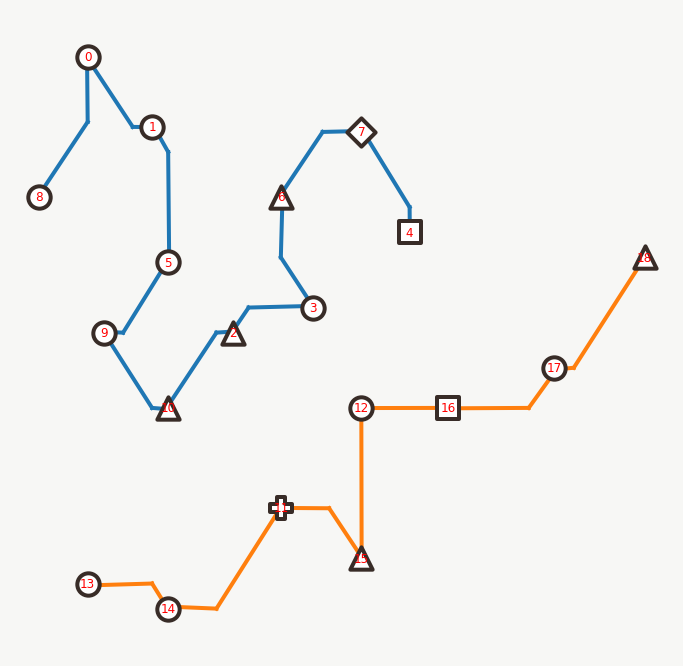

In [7]:
graph(stations, rails)

## Stage 2 - MIP Approach

## SDVRP - Based Implementation

**Origin**: Archetti et al.'s Tabu search paper <a href="https://www.jstor.org/stable/25769283">here</a> though it is expanded on in **The Split Delivery Vehicle Routing Problem: A Survey** (Archetti et al.) <a href=" https://www-or.amp.i.kyoto-u.ac.jp/ramp2006/paper/2-1.pdf">here</a>

### Modifications made to the SDVRP model above:

0. I have been setting 'demands' to be inversely proportional to the 'centre' of the city network; this is to introduce higher-demand cities in an attempt to promote crossings.
1. Added a single 'dummy depot' from which all vehicles must leave and enter. This is to detach from 'specified/fixed depot' concept.
2. Added extra constraints to discourage self-joins (could probably merge into another constraint)
3. Added extra constraints to enforce that all vehicles must leave, and enter, dummy depot exactly once
4. Switched from DFJ SEC's to MTZ SEC's; I feel it is easier to work with when it comes to allowing loops within a route, and furthermore avoids exponentially many constraints
5. Modified MTZ SEC to 'allow' a subtour-forming join IF that node would connect directly to the dummy depot

> (Refresher: MTZ SEC's) $u_i − u_j+ px_{ij} \leq p − 1\quad\forall i,j \in V$ (here $p$ = `N_STATIONS`)

> (What I used) $u_i^{[k]} − u_j^{[k]}+ px_{ij}^{[k]} \leq p − 1 + px_{jD}^{[k]}\quad\forall i,j \in V,\ k\in D$

- Idea: if (i -> j), if j is not the last trainstop prior to a depot, then it's just ordinary MTZ but per-route
- If however (i -> j) and (j -> depot) then (because we'll have u[j,k] = 0 < u[i,k]) we add in p again 

6. Capacities of vehicles/trains are homogenous, but easily modifiable

In [ ]:
def sdvrp(city, verbose=True):
    
    # A few modifications, but otherwise the same hyperparameters
    n = n_stations = len(city.stations)  # no. customers
    M = 4
    D = range(M) # set of vehicles
    S = list(range(n_stations))
    V = S  # customers
    DUMMY = n  # dummy depot's index
    V0 = S + [DUMMY]  # customers + depot

    Q = n  # capacities of vehicles (assumed homogenous)
    K = 1 # 3
    L = 100 # N_STATIONS - (M-1)*K
    mk = 1 # Num trains from kth depot

    # Slightly larger cost matrix, just with a row/col of zeros for the dummy depot
    cost = np.zeros([n+1,n+1])
    cost[:n,:n] = gen_distance_matrix(city) 

    # Demands. Unit demands is TSP-like if capacity Q = |S|
    # d = np.ones([n])

    # OR assign demand based on centrality. Normalise demand to ensure feasibility
    # d = demand_by_centrality(city.stations, C=2)
    # d = d * Q * M / d.sum()

    # ALT: unit demands
    d = [1]*n
    
    # Special-case: A `hexagon` demand assignment to showcase overlapping
    # d = [0.8, 8, 0.8, 8, 0.8, 0.8, 0.8]

    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)
        
    MIN_EDGES = 1  # relevant to an extra constraint that avoids short-lived train stops; Ants approach would do better here

    x = m.addVars(n_stations+1, n_stations+1, M, vtype=GRB.BINARY, name="x") # node i --> node j on path of vehicle k
    y = m.addVars(n_stations, M, lb=0.0, name="y")  # quantity of ith site's demand satisfied by kth vehicle/route
    u = m.addVars(n_stations, M, lb=0.0, name="u")  # MTZ potentials
    p = m.addVars(n_stations, n_stations, lb=0.0, name="p") # Whole-network flow potentials
    e = m.addVars(n_stations, n_stations, vtype=GRB.BINARY, name="e") # indicators for edge use

    m.setObjective(gp.quicksum(cost[i,j]*x[i,j,k] for i in V0 for j in V0 for k in D), GRB.MINIMIZE)
    
    # NEW FLOW CONSTRAINTS FOR A FC GRAPH
    FLOW_ROOT = 0
    
    # first: a flow of 1 must exit a default-designated 'root'
    m.addConstr(gp.quicksum(p[FLOW_ROOT,j] for j in V if j != FLOW_ROOT) == 1) 
    # cannot have self-flows
    m.addConstrs(p[i,i] <= 0 for i in V)
    # Outflow - Inflow = 1 for non-roots (i.e. increase flow by one)
    m.addConstrs(gp.quicksum(p[i,j] for j in V) - gp.quicksum(p[j,i] for j in V) == 1 for i in V if i != FLOW_ROOT)
    # Flow can only occur where an edge is formed
    m.addConstrs(p[i,j] <= (n_stations-1)*gp.quicksum(x[i,j,k] for k in D) for i in V for j in V if i != j)
    # Flow into the root must be N for any edge going into it
    m.addConstrs(p[i, FLOW_ROOT] == n_stations*e[i,FLOW_ROOT] for i in V if i != FLOW_ROOT)
    # Edge-indicator setup
    m.addConstrs(e[i,j] <= 0.5 + gp.quicksum(x[i,j,k] for k in D) for i in V for j in V)
    m.addConstrs(e[i,j] >= gp.quicksum(x[i,j,k] for k in D) / 10e5 for i in V for j in V)

    # EDGE CONSISTENCY CONSTRAINTS
    # 2: at least one edge enters every j (including the depot)
    m.addConstrs(gp.quicksum(x[i,j,k] for i in V0 for k in D) >= 1 for j in V0)
    # 3: in == out for every node + depot, per-route basis (and hence in general)
    m.addConstrs((gp.quicksum(x[i,j,k] for i in V0) - gp.quicksum(x[j,i,k] for i in V0) == 0 for j in V0 for k in D))

    # SUBTOUR CONSTRAINTS 
    # 4_modified: SEC using MTZ
    m.addConstrs((u[i,k] - u[j,k] + n_stations*x[i,j,k] <= n_stations-1 + \
                      n_stations*x[j,DUMMY,k] for i in V for j in V if i != j for k in D))

    # DEMAND CONSTRANTS
    # 5: ith demand can only be sated by route k if there's an outbound edge from i on that path
    m.addConstrs(y[i,k] <= d[i]*gp.quicksum(x[i,j,k] for j in V0) for i in V for k in D)

    # 6: total sated demand @ i must meet demand
    m.addConstrs(gp.quicksum(y[i,k] for k in D) == d[i] for i in V)

    # 7: (MODIFIED FOR HOMOGENOUS CAPACITY) total sated demand by k cannot exceed capacity of vehicle
    m.addConstrs((gp.quicksum(y[i,k] for i in V) <= Q for k in D))

    # 8,9: Domain constraints (already handled)

    # EXTRA constraints
    # X1. No self-joins
    m.addConstrs(x[i,i,k] <= 0 for i in V0 for k in D)
    # X2. For a given k, you must (and only once) enter the dummy depot, and leave the dummy depot
    m.addConstrs(gp.quicksum(x[i,DUMMY,k] for i in V) == mk for k in D)
    m.addConstrs(gp.quicksum(x[DUMMY,i,k] for i in V) == mk for k in D)
    # X3. Perhaps obvious, but the same vehicle cannot cross the same connection twice (excluding depot here is key)
    m.addConstrs((x[i,j,k] + x[j,i,k] <= 1 for i in V for j in V for k in D))
    # X4. Routes must have more than 2 edges
    m.addConstrs((gp.quicksum(x[i,j,k] for i in V0 for j in V0) >= MIN_EDGES for k in D))

    # Special case: Used for testing feasibility of a loop in "loop_feasibility" (3 here is the depot)
    #for a, b in [(3, 2), (2, 1), (1, 0), (0, 2), (2, 3)]:
    #    m.addConstr(x[a,b,0] == 1)

    m.optimize()
    
    return m
    
m = sdvrp(city)

In [ ]:
for var in m.getVars():
    if abs(var.x) > 0:# or var.varName[0] in "p":
        print(var.varName, var.x)

In [ ]:
from ast import literal_eval
SOURCE_IDX = 0
TARGET_IDX = 1
RAIL_IDX = 2
DUMMY = len(city.stations)

connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x' and \
                  literal_eval(v.varName[1:])[SOURCE_IDX] != DUMMY and literal_eval(v.varName[1:])[TARGET_IDX] != DUMMY]
display(connections)

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL_IDX]].append(connection[:2])
    
rail_pairs

In [ ]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs, debug=False))

In [ ]:
graph(stations, rails, jitter=True, equal_aspect=True)

## Ant - Based Implementation (Callum WIP)

In [ ]:
def ant(city, verbose=True):
    
    # A few modifications, but otherwise the same hyperparameters
    n = n_stations = len(city.stations)  # no. customers
    M = 4
    D = range(M) # set of vehicles
    S = list(range(n_stations))
    V = S  # customers
    Y = list(range(n,2*n))  # dummy depots, one per station
    V0 = V + Y
    
    K = 2 # 3
    L = 6 # N_STATIONS - (M-1)*K
    mk = 1 # number of trains per route

    dist = gen_distance_matrix(city)

    # Premise: D routes/vehicles, Y depots, V stations (V0 removed)
    # Routes are: y1 -> v -> ... -> v -> y2, where L & K constrain the number of v
    # This is more general than nonfixed MMTSP as conservation of train entry/exit @ depots is not necessary, only in aggregate

    # Redefining parameters
    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)

    # node i --> node j on path from depot k (nodes include depots)
    x = m.addVars(2*n, 2*n, M, vtype=GRB.INTEGER, name="x")
    # node i potential, ONLY for actual customers (not dummy) MODIFIED
    u = m.addVars(n, M, vtype=GRB.CONTINUOUS, lb=0.0, name="u")
    # NEW FLOW VARIABLES
    p = m.addVars(n_stations, n_stations, lb=0.0, name="p") # Whole-network flow potentials
    e = m.addVars(n_stations, n_stations, vtype=GRB.BINARY, name="e") # indicators for edge use

    m.setObjective(gp.quicksum(dist[i, j]*x[i, j, k] for k in D for j in V for i in V), GRB.MINIMIZE)
    
    # NEW FLOW CONSTRAINTS FOR A FC GRAPH
    FLOW_ROOT = 0
    # first: a flow of 1 must exit a default-designated 'root'
    m.addConstr(gp.quicksum(p[FLOW_ROOT,j] for j in V if j != FLOW_ROOT) == 1) 
    # cannot have self-flows
    m.addConstrs(p[i,i] <= 0 for i in V)
    # Outflow - Inflow = 1 for non-roots (i.e. increase flow by one)
    m.addConstrs(gp.quicksum(p[i,j] for j in V) - gp.quicksum(p[j,i] for j in V) == 1 for i in V if i != FLOW_ROOT)
    # Flow can only occur where an edge is formed
    m.addConstrs(p[i,j] <= (n_stations-1)*gp.quicksum(x[i,j,k] for k in D) for i in V for j in V if i != j)
    # Flow into the root must be N for any edge going into it
    m.addConstrs(p[i, FLOW_ROOT] == n_stations*e[i,FLOW_ROOT] for i in V if i != FLOW_ROOT)
    # Edge-indicator setup
    m.addConstrs(e[i,j] <= 0.5 + gp.quicksum(x[i,j,k] for k in D) for i in V for j in V)
    m.addConstrs(e[i,j] >= gp.quicksum(x[i,j,k] for k in D) / 10e5 for i in V for j in V)

    
    
    # 2 MODIFIED: Must have mk depot entries
    m.addConstrs(gp.quicksum(x[y,j,k] for y in Y for j in V) == mk for k in D)
    # 3: MODIFIED - Enforces that mk train enters each j. Modified to allow cross-over
    m.addConstrs(gp.quicksum(x[i, j, k] for i in V0) >= mk for j in V for k in D)
    # 4: edge consistency for cities
    m.addConstrs(gp.quicksum(x[i, j, k] for i in V0) - gp.quicksum(x[j, i, k] for i in V0) == 0 for k in D for j in V)
    # 5: Must have mk depot exits
    m.addConstrs(gp.quicksum(x[j,y,k] for y in Y for j in V) == mk for k in D)



    # 6: UPPER-BOUND L for u. POTENTIAL CONSTRICTIONS, ESP. ENFORCING L AS A LIMIT.
    # L APPEARS TO 'INCLUDE' THE DEPOT
    m.addConstrs(u[i,k] + (L - 2)*gp.quicksum(x[y, i, k] for y in Y for k in D) - 
                  gp.quicksum(x[i, y, k] for y in Y for k in D) <= L - 1 for i in V for k in D)
    # 7: LOWER-BOUND K for u. READS LIKE FORCING END-OF-LINE STATIONS TO MEET THE LOWER BOUND
    # SEEMS LIKE IF K=3 THEN THERE ARE 3 TRAINSTOPS EXCLUDING THE DEPOT
    m.addConstrs(u[i,k] + gp.quicksum(x[y, i, k] for y in Y for k in D) + \
                 (2 - K)*gp.quicksum(x[i, y, k] for y in Y for k in D) >= 2 for i in V for k in D)
    # 8 IGNORED - INTERFERES WITH LOOPS IN A 'DEPOT-PER-CITY' MODEL
    # m.addConstrs(x[y, i, k] + x[i, y, k] <= 1 for y in Y for i in V for k in D)
    # 9: SEC enforcement, L is a nice proxy here for max potential
    m.addConstrs(u[i,k] - u[j,k] + L*gp.quicksum(x[i,j,k] for k in D) + \
                  (L - 2)*gp.quicksum(x[j,i,k] for k in D) <= L - 1 + \
                      n*gp.quicksum(x[j,y,k] for y in Y) for i in V for j in V if i != j for k in D)


    # 10 MODIFIED - include depot
    m.addConstrs(x[i, i, k] == 0 for i in V0 for k in D)

    # EXTRA constraints (particularly given the ghost depots)
    # X2. (ALREADY GOT IT HERE)
    # X3. Perhaps obvious, but the same vehicle cannot cross the same connection twice (excluding depot here is key)
    m.addConstrs((x[i,j,k] + x[j,i,k] <= 1 for i in V for j in V for k in D))
    # X4. Routes must have more than K edges
    m.addConstrs((gp.quicksum(x[i,j,k] for i in V for j in V) >= K for k in D))
    # X5. Stations can only connect to 'their' depot (reduces symmetry)
    m.addConstrs(gp.quicksum(x[j,y,k]+x[y,j,k] for k in D for y in Y if y != j+n) == 0 for j in V)

    # For `loop_feasibility` loop checking
    # m.addConstr(x[2,1,0] == 1)
    # m.addConstr(x[1,0,0] == 1)
    # m.addConstr(x[0,2,0] == 1)

    m.optimize()
    
    return m

# POTENTIALS WITH DEFAULT 1 ARE ANNOYING ... :(

# HEY 8 MIGHT STOP MULTIPLE TRACKS RETURNING AT THE SAME DEPOT. MODIFY SDVRP.
m = ant(city)

In [ ]:
for var in m.getVars():
    if abs(var.x) > 0 or var.varName[0] in "y":
        print(var.varName, var.x)

In [ ]:
from ast import literal_eval
SOURCE_IDX = 0
TARGET_IDX = 1
RAIL_IDX = 2
n = len(city.stations)

# NOTE BIG CHANGE - NOT != DUMMY. NOW < N TO FACTOR FOR MANY DUMMIES.

# Modified connections definition to disquality report of dummy depot-related edges
connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x' and \
                  literal_eval(v.varName[1:])[SOURCE_IDX] < n and literal_eval(v.varName[1:])[TARGET_IDX] < n]
display(connections)
#connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x' and \
#                  literal_eval(v.varName[1:])[0] < n]

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL_IDX]].append(connection[:2])
    
rail_pairs

In [ ]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs, debug=False))

In [ ]:
graph(stations, rails)

### Random

- `hexagon` + biased demand weights == easy check that overlap is okay
- `loop_feasibility` + negative costs == easy check that loops are okay 
- `donut` == easy check for a problem that needs a loop solution

# Metaheuristics

In [ ]:
from numpy.random import shuffle, randint, choice
from copy import deepcopy

def initialise(N, K):
    x = np.zeros((N, N, K))
    
    order = list(range(N))
    
    for k in range(K):
        shuffle(order)
        for i in range(N-1):
            a = order[i]
            b = order[i+1]
            x[a, b, k] = x[b, a, k] = 1
            
    return x      

isolated_station = lambda x: not all(x.sum(axis=2).sum(axis=0))
rail_covers_every_station = lambda grid: not any(grid.sum(axis=0) == 0)
has_loop = lambda grid: not any(grid.sum(axis=0) == 1)
just_two_stations = lambda grid: (grid.sum() == 2)
get_stations_not_on_line = lambda grid: (grid.sum(axis=0) == 0).nonzero()[0]
get_middle_stations = lambda grid: (grid.sum(axis=0) == 2).nonzero()[0]
get_end_stations    = lambda grid: (grid.sum(axis=0) == 1).nonzero()[0]
get_line_stations   = lambda grid: (grid.sum(axis=0) != 0).nonzero()[0]
has_subtours = lambda grid: len(get_end_stations(grid)) > 2

def get_neighbour(x, case=0):
    x = deepcopy(x)
    # How many lines to modify
    m = 1 + randint(x.shape[2])
    
    lines = list(range(x.shape[2]))
    shuffle(lines)
    
    lines_to_modify = lines[:m]
    
    for k in lines_to_modify:
        grid = x[:, :, k]
        
        case = choice([1, 2, 3, 4]) if case == 0 else case
        
        if case == 1:
            # Case 1. Expand Rail line end (Includes forming loop)
            if not has_loop(grid):
                old_choices = list(get_end_stations(grid))
                new_choices = list(get_stations_not_on_line(grid)) + old_choices
                
                old = choice(old_choices)
                new = choice(new_choices)
                
                if new != old:
                    grid[old, new] = grid[new, old] = 1

        elif case == 2:
            # Case 2. Shrink Rail line end (Includes breaking loop)
            # This can make city invalid (considering station kinds)
            # But cost function makes the cost really high
            if has_loop(grid):
                # Pick edge to break
                choices = np.array(grid.nonzero()).T
                i, j = choices[choice(range(len(choices)))]
                grid[i, j] = grid[j, i] = 0
            else:
                # Pick end to shrink
                ends = get_end_stations(grid)
                old_end = choice(ends)
                new_end = grid[old_end, :].argmax()
                grid[old_end, new_end] = grid[new_end, old_end] = 0

                if isolated_station(x):
                    grid[old_end, new_end] = grid[new_end, old_end] = 1

        elif case == 3:
            # Case 3. Add station in middle
            if not rail_covers_every_station(grid):
                choices = get_stations_not_on_line(grid)
                b = choice(choices)
                
                a = choice(get_line_stations(grid))
                c = grid[a].nonzero()[0]
                
                grid[a, b] = grid[b, a] = grid[b, c] = grid[c, b] = 1
                grid[a, c] = grid[c, a] = 0

        elif case == 4:
            # Case 4. Remove station in middle
            # If not just 2 stations
            if not just_two_stations(grid):
                choices = get_middle_stations(grid)
                b = choice(choices)
                a, c = grid[b, :].nonzero()[0]
                grid[a, b] = grid[b, a] = grid[b, c] = grid[c, b] = 0
                prev_ac = grid[a, c]
                grid[a, c] = grid[c, a] = 1

                if isolated_station(x):
                    grid[a, b] = grid[b, a] = grid[b, c] = grid[c, b] = 1
                    grid[a, c] = grid[c, a] = prev_ac
        
    return x


import networkx as nx
from networkx import from_numpy_matrix

M = 1e5

def cost(stations, x):
    connections = 1 * (x.sum(axis=2) > 0)
    dist = gen_distance_matrix(city).round(2)
    # weighted_adjacency is edge weight where edge exists, else 0
    weighted_adjacency = connections * dist
    G = from_numpy_matrix(weighted_adjacency)
    
    all_paths = list(nx.all_pairs_shortest_path(G))
    
    station_dists = []
    all_kinds = {s.kind for s in stations}

    # For each starting station
    for i, paths in all_paths:
        start = stations[i]

        distances = {kind: M for kind in all_kinds if kind != start.kind}

        # Get its kind
        for j, path in paths.items():
            end = stations[j]
            # For each other station: If kind is different
            if start.kind != end.kind:
                rails = [stations[i] for i in path]
                # Work out distance to that station and retain if min
                distances[end.kind] = min(distances[end.kind], total_distance(rails))

        station_dists.append(sum(distances.values()))
        
    return sum(station_dists) + len(G.edges) / M


In [ ]:
x1 = np.array([
[[0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 1, 0]],
[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 1, 0]]
]).transpose(2, 1, 0)

x1[:, :, 0]

In [ ]:
x2 = np.array([
[[0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1, 0]],
[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0]]
]).transpose(2, 1, 0)

x2[:, :, 0]

In [ ]:
print(cost(city.stations, x1))

graph_x(city.stations, x1)

In [ ]:
print(cost(city.stations, x2))

graph_x(city.stations, x2)

In [ ]:
nn = get_neighbour(x1)

print(cost(city.stations, nn))

graph_x(city.stations, nn)

# Simulated Annealing

In [ ]:
def simulated_annealing(stations, K):
    ''' Performs simulated annealing to find (try and find) the optimal configuration 
        K is number of lines '''
    # Initialise Configuration
    cur_x = initialise(len(stations), K)
    cur_cost = cost(stations, cur_x)
    best_x, best_cost = cur_x, cur_cost
    
    # Maximum iterations
    max_iter = 100
    CUTOFF_VAL = 0.001
    
    # Time
    t = 0
    
    while True:
        # Update current temperature
        T = np.exp(np.log(CUTOFF_VAL)*t / max_iter)
        if T < CUTOFF_VAL:
            # Return configuration and its value
            return best_x, best_cost
        
        # Make random change
        new_x = get_neighbour(cur_x)
        new_cost = cost(stations, new_x)
        
        # Keep change if it is an improvement (or randomly sometimes)
        if new_cost < cur_cost or np.random.uniform(0, 1) < T:
            cur_x, cur_cost = new_x, new_cost
            
            if cur_cost < best_cost:
                best_x, best_cost = cur_x, cur_cost
            
        t += 1
        
best_x, best_cost = None, M
for restart in tqdm(range(1)):
    res_x, res_cost = simulated_annealing(city.stations, K=2)
    if res_cost < best_cost:
        best_x, best_cost, res_x, res_cost
        print(best_cost)

# Computational Studies

In [ ]:
from time import time
from tqdm import tqdm

def experiment(n_stations_range, num_trials, formulation, verbose=True):
    
    # Store results
    res_n_stations = []
    res_time_taken = []
    
    iterator = tqdm(n_stations_range) if verbose else n_stations_range
    
    for n_stations in iterator:
        for _ in range(num_trials):
            
            t0 = time()
            formulation(City(n_stations), verbose=False)
            t1 = time()
            
            res_n_stations.append(n_stations)
            res_time_taken.append(t1 - t0)
            
    return res_n_stations, res_time_taken

In [ ]:
tsp_n_stations, tsp_time_taken = experiment(range(2, 18), 5, tsp)

In [ ]:
sdvrp_n_stations, sdvrp_time_taken = experiment(range(2, 9), 5, sdvrp)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import defaultdict

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

fig, ax = plt.subplots(figsize=(16, 9))

results = {'TSP': (tsp_n_stations, tsp_time_taken), 'SDVRP': (sdvrp_n_stations, sdvrp_time_taken)}

def get_sum_stats(x, y):
    vals = defaultdict(list)
    
    for x_, y_ in zip(x, y):
        vals[x_].append(y_)
        
    xs = []
    means = []
    sds = []
    mins = []
    maxs = []
    for x, ys in vals.items():
        ys = np.array(ys)
        xs.append(x)
        means.append(ys.mean())
        sds.append(ys.std())
        mins.append(ys.min())
        maxs.append(ys.max())
        
    return np.array(xs), np.array(means), np.array(sds), np.array(mins), np.array(maxs)

for i, (name, (res_n_stations, res_tsp_time_taken)) in enumerate(results.items()):
    col = f'C{i}'
    #ax.scatter(res_n_stations, res_tsp_time_taken, alpha=0.3, color=col)
    xs, means, sds, mins, maxs = get_sum_stats(res_n_stations, res_tsp_time_taken)
    ax.plot(xs, means, lw=LW, alpha=0.5, color=col, label=name)
    ax.fill_between(xs, mins, maxs, lw=0, alpha=0.5, color=col)

ax.set_title('Runtime Comparison of Methods')
ax.set_xlabel('# Stations')
ax.set_ylabel('Runtime (s)')

ax.legend(frameon=False)

sns.despine()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import defaultdict

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

fig, ax = plt.subplots(figsize=(16, 9))

results = {'TSP': (tsp_n_stations, tsp_time_taken), 'SDVRP': (sdvrp_n_stations, sdvrp_time_taken)}

def get_sum_stats(x, y):
    vals = defaultdict(list)
    
    for x_, y_ in zip(x, y):
        vals[x_].append(y_)
        
    xs = []
    means = []
    sds = []
    mins = []
    maxs = []
    for x, ys in vals.items():
        ys = np.array(ys)
        xs.append(x)
        means.append(ys.mean())
        sds.append(ys.std())
        mins.append(ys.min())
        maxs.append(ys.max())
        
    return np.array(xs), np.array(means), np.array(sds), np.array(mins), np.array(maxs)

for i, (name, (res_n_stations, res_tsp_time_taken)) in enumerate(results.items()):
    col = f'C{i}'
    #ax.scatter(res_n_stations, res_tsp_time_taken, alpha=0.3, color=col)
    xs, means, sds, mins, maxs = get_sum_stats(res_n_stations, res_tsp_time_taken)
    ax.plot(xs, means, lw=LW, alpha=0.5, color=col, label=name)
    ax.fill_between(xs, mins, maxs, lw=0, alpha=0.5, color=col)

ax.set_title('Runtime Comparison of Methods')
ax.set_xlabel('# Stations')
ax.set_ylabel('Runtime (s)')

ax.legend(frameon=False)

sns.despine()

plt.show()